In [2]:
"""IMPORTS
"""

import sys
#sys.path.append("../DBL-Data-Challenge")
from database.connect import getConnection
import pandas as pd
import seaborn as sns
sns.set()
import random
import matplotlib.pyplot as plt
from globals import airlineIDs
import re

"""MODEL IMPORTS
"""
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

ModuleNotFoundError: No module named 'transformers'

In [ ]:
text = preprocess(str('I just went on a weekend trip to Hawaii with @Dani531 and it was awesome! https://en.wikipedia.org/wiki/Hawaii'))
print(text)

In [ ]:
try:
    connection1 = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

In [ ]:
"""Loads all the relevant data, this takes ~10 min.
"""

# Connects to database
cursor = connection1.cursor()

print("The tweets are being queried")
query="SELECT text, user_id, user_mentions FROM tweets"
cursor.execute(query)

print('The tweets are being fetched')
texts = cursor.fetchall()
number_tweets = cursor.rowcount
print("Total number of rows in table: ", number_tweets)

# Index column is being added
#print("Index is being added")
query= "DROP TABLE tweets_with_index"
cursor.execute(query)

# Create new table will the relevant data
query= "CREATE TABLE tweets_with_index SELECT ROW_NUMBER() OVER() AS row_num, text, user_id, user_mentions FROM tweets"
cursor.execute(query)
print('Index added')

# Generate random list
randomlist = []
for i in range(0, 6000):
    n = random.randint(0, number_tweets-1)
    randomlist.append(n)

# Make list of languages
print("The sentiment is being detected")
sentiment_list = []
user_mention_list = []
for i in randomlist:  
    try:
        # Sentiment detection
        text = preprocess(str(texts[i][0]))
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        score_tuple = (scores[ranking[0]], scores[ranking[1]], scores[ranking[2]])
        #print(sum(score_tuple))  
        sentiment_list.append(score_tuple)
        # User mentions
        dicts_str = (texts[i][2])
        tweet_mentions_list = re.findall("'id':\s*(\d*)", dicts_str)
        user_mention_list.append(tweet_mentions_list)
    except Exception:
        sentiment_list.append('NI')
        user_mention_list.append('Null')


#print(sentiment_list)
#print(user_mention_list)

# Add the result to the table (Probably needs some modifications)
"""
print("The tweets are being added to the table")
for i, j in enumerate(lang_list): # i = index, j = language
    query = f"UPDATE tweets_with_index SET lang = '{str(j)}' WHERE row_num = {int(i+1)}"
    cursor.execute(query)
"""

"""
print("A selection is being fetched to show that everything when correctly")
query = "SELECT * FROM tweets_with_index LIMIT 5"
cursor.execute(query)
head = cursor.fetchall()

print("The first 5 rows are being printed:")
for row in head:
    print(row)

"""
cursor.close()
connection1.close()
print('Connection closed!')

In [ ]:
sentiment_df = pd.DataFrame(columns=['pos', 'neg', 'neu'])
for i, tuple in enumerate(sentiment_list):
    sentiment_df.loc[i, 'pos'] = tuple[0]
    sentiment_df.loc[i, 'neg'] = tuple[1]
    sentiment_df.loc[i, 'neu'] = tuple[2]

sentiment_df

In [ ]:
mean_senti_df = pd.DataFrame(columns=['pos', 'neu', 'neg'])
mean_senti_df.loc[0, 'pos'] = sentiment_df['pos'].mean()
mean_senti_df.loc[0, 'neu'] = sentiment_df['neu'].mean()
mean_senti_df.loc[0, 'neg'] = sentiment_df['neg'].mean()
mean_senti_df.head()

In [ ]:
ax = sns.barplot(mean_senti_df)
ax.set_title("Mean sentiment of tweets (sample size 3000)")
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage of detection (%)')

### User mentions

In [8]:
# Add user mentions to dataframe (list of user IDs)
sentiment_df['mentions'] = user_mention_list
sentiment_df.head()

,pos,neg,neu,mentions
0,0.731784,0.259369,0.008847,[119177810]
1,0.743798,0.131007,0.125196,[18332190]
2,0.943951,0.050285,0.005764,"[22536055, 15519886]"
3,0.89605,0.056843,0.047107,[253340062]
4,0.787984,0.195462,0.016554,"[18680839, 22536055]"


In [9]:
# Detect the users 
# (what airline is it? Or is it not an airline?)
sentiment_df['user_mentions'] = 'Null'
sentiment_df['airline'] = 'Null'

# For every list of mentions per tweet
for i, mentions in enumerate(sentiment_df['mentions']):

    mentions_list = []
    airline = 'no_airline'
    # check for every mention
    added = False
    for mention in mentions:
        # if the mention is an airline
        added = False
        for key in airlineIDs:
            if int(mention) == int(airlineIDs[key]):
                mentions_list.append(key)
                airline = key
                added = True
                continue
        if added == False:
            mentions_list.append('not_airline')
    if added == False:
        airline = 'no_airline'
        #airlines.append('no_airline')
    sentiment_df['user_mentions'][i] = mentions_list
    sentiment_df['airline'][i] = airline

#lang_df = lang_df.drop(labels=-1, axis=0)
sentiment_df.head()

,pos,neg,neu,mentions,user_mentions,airline
0,0.731784,0.259369,0.008847,[119177810],[not_airline],no_airline
1,0.743798,0.131007,0.125196,[18332190],[BritishAirways],BritishAirways
2,0.943951,0.050285,0.005764,"[22536055, 15519886]","[AmericanAir, not_airline]",no_airline
3,0.89605,0.056843,0.047107,[253340062],[SingaporeAir],SingaporeAir
4,0.787984,0.195462,0.016554,"[18680839, 22536055]","[not_airline, AmericanAir]",AmericanAir


### Sentiment per airline

In [10]:
# Group by airline and sentiment
sentiment_df = sentiment_df.groupby(['airline'])[['pos', 'neg', 'neu']].mean()
sentiment_df.head()

,pos,neg,neu
airline,,,
AirFrance,0.792127,0.187487,0.020386
AmericanAir,0.796134,0.178674,0.025192
BritishAirways,0.795556,0.181250,0.023193
EtihadAirways,0.841252,0.143340,0.015408
KLM,0.805124,0.176976,0.017900


<Axes: xlabel='airline'>

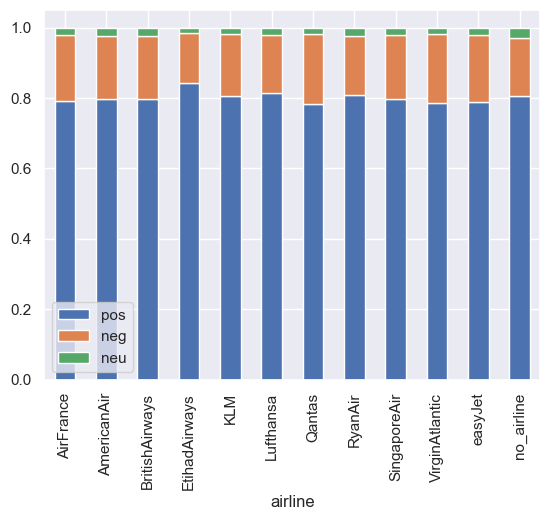

In [11]:
# Plot stacked bar chart: sentiment per airline
sentiment_df.plot(kind='bar', stacked=True, ) 

In [50]:
# Detect sentiment per airline
